## Descripción Matemática del Problema

El código describe la solución fundamental de la ecuación de Helmholtz en 2D.


$$ \nabla^2 \Phi + k^2 \Phi = -\delta(x - x_0, y - y_0), $$

donde:

- $\nabla^2$ es el operador Laplaciano en 2D.
- $\Phi(x, y)$ es la función desconocida que representa la solución.
- $k$ es el número de onda, relacionado con la longitud de onda $\lambda$ por $k = \frac{2\pi}{\lambda}$.
- $\delta(x - x_0, y - y_0)$ es la función delta de Dirac, que representa una fuente puntual en la posición $(x_0, y_0)$.


##  Solución Fundamental
La solución fundamental de la ecuación de Helmholtz en 2D para una fuente puntual en el origen $(x_0, y_0) = (0, 0)$ está dada por:

$$ \Phi(x, y) = \frac{i}{4} H_0^{(1)}(kR), $$

donde:

- $H_0^{(1)}$ es la función de Hankel de primera especie y orden cero.
- $R = \sqrt{(x - x_0)^2 + (y - y_0)^2}$ es la distancia radial desde la fuente puntual.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel1,hankel2
import os
import torch 
import torch.nn as nn
from functools import partial

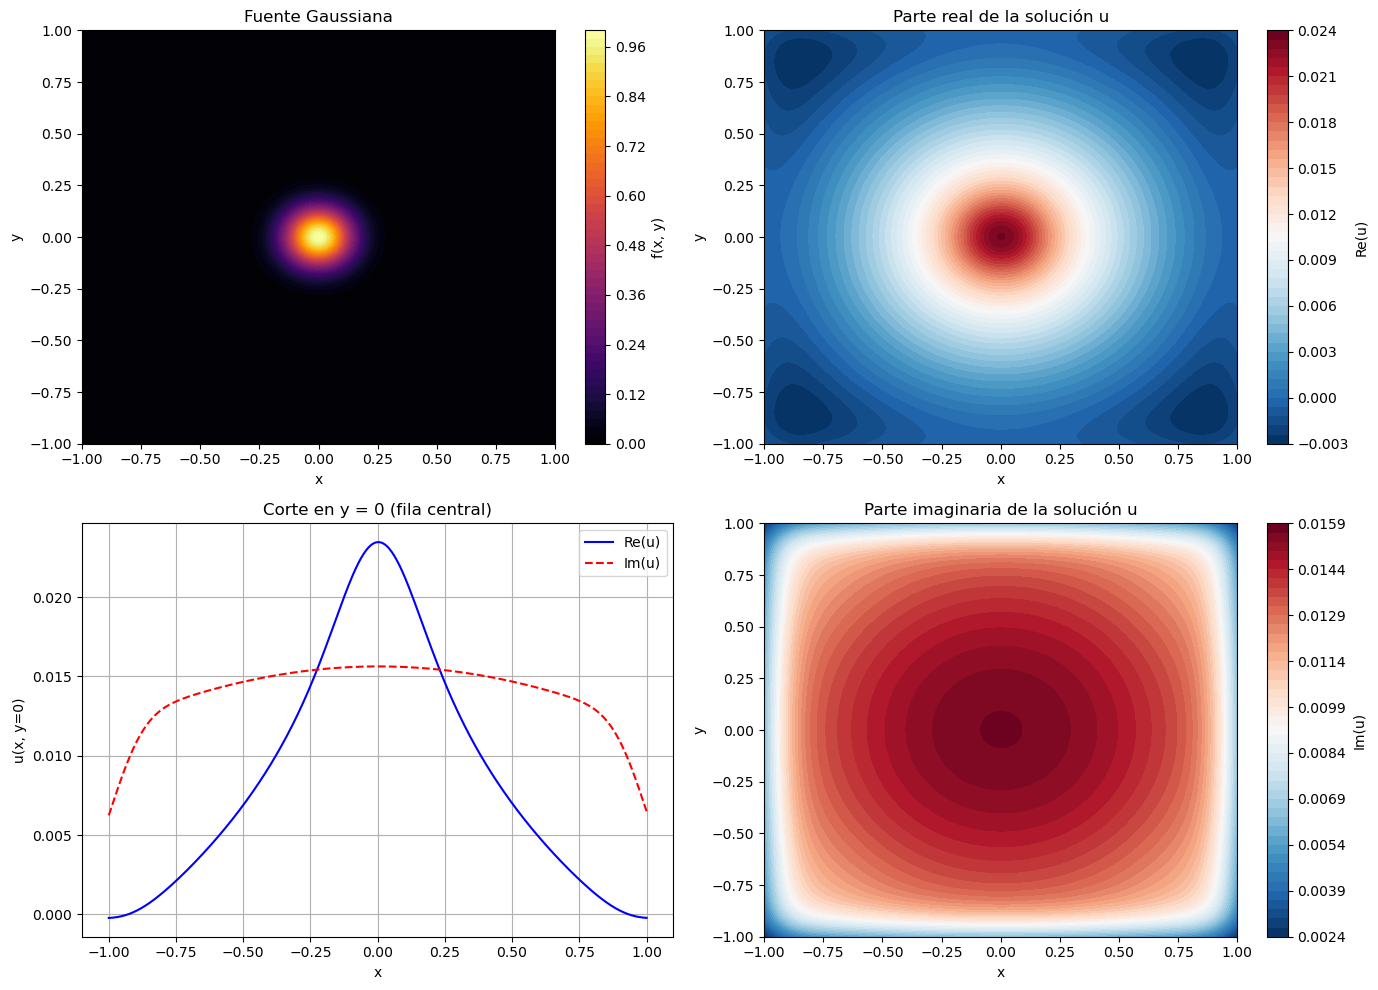

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel2
from scipy.signal import fftconvolve

# Parámetros del problema
k = 1                      # Número de onda
x0, y0 = 0.0, 0.0           # Centro de la fuente gaussiana
sigma = 0.1                # Desviación estándar de la fuente

# Malla 2D
n = 400
x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
X, Y = np.meshgrid(x, y)

# Fuente gaussiana
f = np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))

# Construcción de R y solución fundamental
dx = x[1] - x[0]
dy = y[1] - y[0]
Xg, Yg = np.meshgrid(x - x0, y - y0)
R = np.sqrt(Xg**2 + Yg**2)
R[R == 0] = np.finfo(float).eps  # Evitar singularidad en el origen

# Solución fundamental de Helmholtz en 2D
Phi = (1j / 4) * hankel1(0, k * R)

# Convolución f * Phi usando FFT (modo 'same' para mantener tamaño)
u = fftconvolve(f, Phi, mode='same') * dx * dy  # dx*dy para aproximar integral

# Índice de la fila central
mid = n // 2

# ============ GRAFICACIÓN ============

plt.figure(figsize=(14, 10))

# (1) Fuente gaussiana
plt.subplot(2, 2, 1)
plt.contourf(x, y, f, levels=50, cmap='inferno')
plt.colorbar(label='f(x, y)')
plt.title('Fuente Gaussiana')
plt.xlabel('x')
plt.ylabel('y')

# (2) Parte real del campo u
plt.subplot(2, 2, 2)
plt.contourf(x, y, np.real(u), levels=50, cmap='RdBu_r')
plt.colorbar(label='Re(u)')
plt.title('Parte real de la solución u')
plt.xlabel('x')
plt.ylabel('y')

# (3) Corte de la solución: parte real
plt.subplot(2, 2, 3)
plt.plot(x, np.real(u[mid, :]), label='Re(u)', color='blue')
plt.plot(x, np.imag(u[mid, :]), label='Im(u)', color='red', linestyle='--')
plt.title('Corte en y = 0 (fila central)')
plt.xlabel('x')
plt.ylabel('u(x, y=0)')
plt.grid(True)
plt.legend()

# (4) Parte imaginaria del campo u
plt.subplot(2, 2, 4)
plt.contourf(x, y, np.imag(u), levels=50, cmap='RdBu_r')
plt.colorbar(label='Im(u)')
plt.title('Parte imaginaria de la solución u')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()


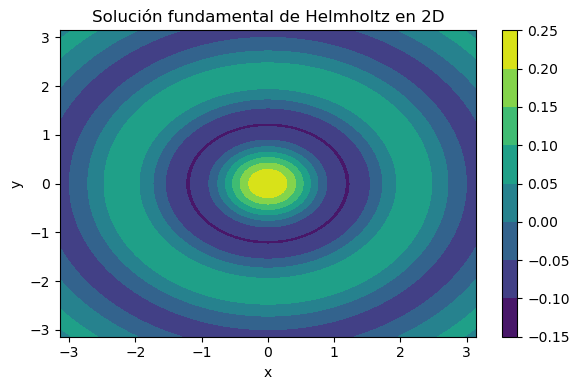

In [8]:

# Parámetros
k = 10 # número de onda
x0, y0 = 0.0, 0.0  # fuente puntual en el origen

# Malla 2D
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
R = np.sqrt((X - x0)**2 + (Y - y0)**2)

# Solución fundamental de Helmholtz en 2D (evitamos singularidad en R=0)
Phi = (1j / 4) * hankel2(0, k * R)

# Graficar parte real
plt.figure(figsize=(6, 4))
plt.contourf(np.imag(Phi), extent=[-np.pi, np.pi, -np.pi, np.pi])
plt.colorbar()
plt.title('Solución fundamental de Helmholtz en 2D')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

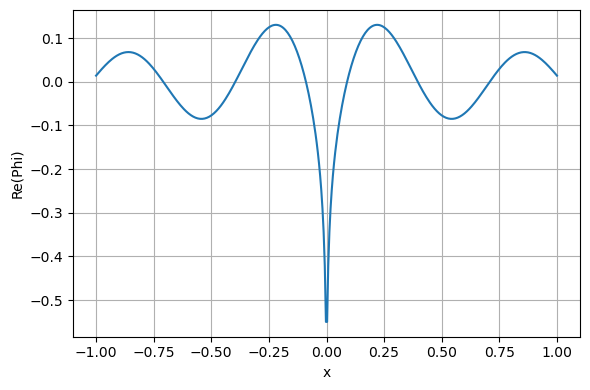

In [9]:
# Graficar la fila central de la parte real de Phi
central_row = np.real(Phi)[Phi.shape[0] // 2, :]  # Fila central
plt.figure(figsize=(6, 4))
plt.plot(x, central_row)
plt.xlabel('x')
plt.ylabel('Re(Phi)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [98]:
central_row[200]

np.float64(-0.5206722529330894)

## Delta de dirac

## PINNs



In [33]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        """
        Initializes a more general neural network model.

        Args:
            input_size (int): The size of the input layer.
            output_size (int): The size of the output layer.
            hidden_layers (int): The number of hidden layers.
            hidden_units (int): The number of units in each hidden layer.
            activation_function (nn.Module): The activation function to use in the hidden layers.
        """
        super(MLP, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the neural network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor of the network.
        """
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x    

def set_seed(seed: int = 42):
    """
    Sets the seed for generating random numbers to ensure reproducibility of results.

    Args:
        seed (int, optional): The seed value to use for random number generation. Defaults to 42.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    Computes the derivative of a given tensor 'dy' with respect to another tensor 'x',
    up to a specified order.

    Args:
        dy (torch.Tensor): The tensor whose derivative is to be computed.
        x (torch.Tensor): The tensor with respect to which the derivative is to be computed.
        order (int, optional): The order of the derivative to compute. Defaults to 1, which
                               means a first-order derivative. Higher orders result in higher-order
                               derivatives.

    Returns:
        torch.Tensor: The computed derivative of 'dy' with respect to 'x', of the specified order.
    """
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy  

def init_weights(m):
    """
    Initializes the weights and biases of a linear layer in the neural network using Xavier normalization.

    Args:
        m: The module or layer to initialize. If the module is of type nn.Linear, its weights and biases
           will be initialized.
    """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)
      


def f(model, x_f, y_f, k, x_0=0.0, y_0=0.0, delta_strength=1.0):
    """
    Calculate the Helmholtz equation components for the given model and input domain,
    including a Dirac delta source term.

    Parameters:
    model (torch.nn.Module): The neural network model.
    x_f (torch.Tensor): Tensor of x-coordinates of the input domain.
    y_f (torch.Tensor): Tensor of y-coordinates of the input domain.
    k (float): Wave number.
    x_0 (float): x-coordinate of the source point (default is 0.0).
    y_0 (float): y-coordinate of the source point (default is 0.0).
    delta_strength (float): Strength of the Dirac delta source term (default is 1.0).

    Returns:
    torch.Tensor: Real part of the Helmholtz equation components.
    torch.Tensor: Imaginary part of the Helmholtz equation components.
    """
    # Concatenate x_f and y_f to form the input domain
    domain = torch.stack((x_f, y_f), dim=1)
    
    # Pass the domain through the model to get the output
    u = model(domain)
    
    # Extract real and imaginary parts
    u_real = u[:, 0]
    u_imag = u[:, 1]
    
    # Calculate second-order derivatives
    u_real_xx = derivative(u_real, x_f, order=2)
    u_real_yy = derivative(u_real, y_f, order=2)
    u_imag_xx = derivative(u_imag, x_f, order=2)
    u_imag_yy = derivative(u_imag, y_f, order=2)
    
    # Calculate the Dirac delta term
    delta = torch.exp(-((x_f)**2 + (y_f)**2) / (2 * 0.1**2))
    
    # Calculate the Helmholtz equation components
    f_u_real = u_real_xx + u_real_yy + k**2 * u_real - delta
    f_u_imag = u_imag_xx + u_imag_yy + k**2 * u_imag - delta
    
    return f_u_real, f_u_imag


def mse_f(model, x_f, y_f, k):
    """
    Calculate the mean squared error (MSE) for the Helmholtz equation components.

    Parameters:
    model (torch.nn.Module): The neural network model.
    x_f (torch.Tensor): Tensor of x-coordinates of the input domain.
    y_f (torch.Tensor): Tensor of y-coordinates of the input domain.
    k (float): Wave number.

    Returns:
    torch.Tensor: Mean squared error for the Helmholtz equation components.
    """
    # Calculate f(x, y) from the neural network
    f_u_real, f_u_imag = f(model, x_f, y_f, k)
    
    # Calculate the mean squared error for the real and imaginary parts
    error_f_real = torch.mean(f_u_real**2)
    error_f_imag = torch.mean(f_u_imag**2)
    
    # Sum the errors to obtain the total MSE
    mse = error_f_real + error_f_imag
      
    return mse

def mse_b(model, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k):
    """
    Calculate the mean squared error (MSE) for boundary conditions of a scattering problem.
    Parameters:
    model (torch.nn.Module): The neural network model used to approximate the solution.
    x_left (torch.Tensor): x-coordinates of the left boundary points.
    y_left (torch.Tensor): y-coordinates of the left boundary points.
    x_right (torch.Tensor): x-coordinates of the right boundary points.
    y_right (torch.Tensor): y-coordinates of the right boundary points.
    x_bottom (torch.Tensor): x-coordinates of the bottom boundary points.
    y_bottom (torch.Tensor): y-coordinates of the bottom boundary points.
    x_top (torch.Tensor): x-coordinates of the top boundary points.
    y_top (torch.Tensor): y-coordinates of the top boundary points.
    k (float): Wave number.
    Returns:
    float: The total mean squared error for all boundary conditions.
    """
    def calculate_mse_boundary(x, y, model, k, boundary_type):
        domain = torch.stack((x, y), axis=1)
        u = model(domain)
        u_real = u[:, 0]
        u_imag = u[:, 1]

        if boundary_type in ['left', 'right']:
            du_real_dx = derivative(u_real, x, order=1)
            du_imag_dx = derivative(u_imag, x, order=1)
            du_real_dn = (-1 if boundary_type == 'left' else 1) * du_real_dx
            du_imag_dn = (-1 if boundary_type == 'left' else 1) * du_imag_dx
            error_real = du_real_dn - (-k * u_imag)
            error_imag = du_imag_dn - (k * u_real)
        
        elif boundary_type in ['bottom', 'top']:
            du_real_dy = derivative(u_real, y, order=1)
            du_imag_dy = derivative(u_imag, y, order=1)
            du_real_dn = (-1 if boundary_type == 'bottom' else 1) * du_real_dy
            du_imag_dn = (-1 if boundary_type == 'bottom' else 1) * du_imag_dy
            error_real = du_real_dn - (-k * u_imag)
            error_imag = du_imag_dn - (k * u_real)
        
        mse = ((error_real)**2 + (error_imag)**2).mean()
        return mse

    # Boundary MSE
    mse_left = calculate_mse_boundary(x_left, y_left, model, k, 'left')
    mse_right = calculate_mse_boundary(x_right, y_right, model, k, 'right')
    mse_bottom = calculate_mse_boundary(x_bottom, y_bottom, model, k, 'bottom')
    mse_top = calculate_mse_boundary(x_top, y_top, model, k, 'top')

    # Add condition for (x=0, y=0)
    x_center = torch.tensor([0.0], device=x_left.device, requires_grad=True)
    y_center = torch.tensor([0.0], device=y_left.device, requires_grad=True)
    u_center = model(torch.stack((x_center, y_center), dim=1))
    u_center_real = u_center[:, 0]
    u_center_imag = u_center[:, 1]
 

    # Total MSE
    mse = mse_left + mse_right + mse_bottom + mse_top #+ 10*mse_center   
    return mse

def train_adam(model, x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k, num_iter=5_000):
 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    global iter
     
    for i in range(1, num_iter + 1):
        optimizer.zero_grad()
        loss_f = mse_f(model, x_f, y_f, k)
        loss_b = mse_b(model, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k)
        loss = loss_f + loss_b
        loss.backward(retain_graph=True)
        optimizer.step()
        iter += 1
        if iter % 1000 == 0:
            print(f"Adam - Iter: {iter} - Loss: {loss.item()}")


def closure(model, optimizer, x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k):
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Calculate the loss
    loss_f = mse_f(model, x_f, y_f, k)
    loss_b = mse_b(model, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k)
    loss =  loss_f
    
    # Backpropagate the loss
    loss.backward(retain_graph=True)
    
    # Update iteration counter and print loss every 100 iterations
    global iter
    iter += 1
    if iter % 1000 == 0:
        print(f"Iteration {iter}, Loss: {loss.item()}")
            
    return loss


# Function for L-BFGS training
def train_lbfgs(model, x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k, num_iter=5_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
 
    closure_fn = partial(closure, model, optimizer, x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k)
    optimizer.step(closure_fn)



def generate_points(n_Omega_P, side_length, r_i, n_Gamma_I, n_boundary_e):
    """
    Generate points inside the domain and on the boundaries.

    Parameters:
    n_Omega_P (int): Number of points inside the annular region.
    side_length (float): Side length of the square.
    r_i (float): Inner radius.
    n_Gamma_I (int): Number of points on the inner boundary.
    n_boundary_e (int): Number of points on each boundary.
    device (torch.device): Device to store the tensors.

    Returns:
    tuple: Tensors of x and y coordinates for points inside the domain, 
           on the inner boundary, and on the left, right, bottom, and top boundaries.
    """
    # Set the device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Generate random samples for points inside the square
    points = []
    while len(points) < n_Omega_P:
        x_samples = side_length * (np.random.rand(n_Omega_P) - 0.5)
        y_samples = side_length * (np.random.rand(n_Omega_P) - 0.5)
        points.extend(zip(x_samples, y_samples))

    # Trim the list to the desired number of points
    points = points[:n_Omega_P]
    x_samples, y_samples = zip(*points)

    # Convert to numpy arrays
    x_f = np.array(x_samples)
    y_f = np.array(y_samples)



    # Generate random points on the left, right, bottom, and top boundaries of the square

    # Generate point at the center of the  square
    x_f = np.append(x_f, 0)
    y_f = np.append(y_f, 0)

    # Left boundary (excluding corners)
    y_left = side_length * (np.random.rand(n_boundary_e) - 0.5)
    x_left = -side_length / 2 * np.ones_like(y_left)

    # Right boundary (excluding corners)
    y_right = side_length * (np.random.rand(n_boundary_e) - 0.5)
    x_right = side_length / 2 * np.ones_like(y_right)

    # Bottom boundary (excluding corners)
    x_bottom = side_length * (np.random.rand(n_boundary_e) - 0.5)
    y_bottom = -side_length / 2 * np.ones_like(x_bottom)

    # Top boundary (excluding corners)
    x_top = side_length * (np.random.rand(n_boundary_e) - 0.5)
    y_top = side_length / 2 * np.ones_like(x_top)

    # Convert to torch tensors
    x_f = torch.from_numpy(x_f).float().to(device).requires_grad_(True)
    y_f = torch.from_numpy(y_f).float().to(device).requires_grad_(True)
    x_left = torch.from_numpy(x_left).float().to(device).requires_grad_(True)
    y_left = torch.from_numpy(y_left).float().to(device).requires_grad_(True)
    x_right = torch.from_numpy(x_right).float().to(device).requires_grad_(True)
    y_right = torch.from_numpy(y_right).float().to(device).requires_grad_(True)
    x_bottom = torch.from_numpy(x_bottom).float().to(device).requires_grad_(True)
    y_bottom = torch.from_numpy(y_bottom).float().to(device).requires_grad_(True)
    x_top = torch.from_numpy(x_top).float().to(device).requires_grad_(True)
    y_top = torch.from_numpy(y_top).float().to(device).requires_grad_(True)

    return x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top
 
def plot_points(x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top):
    """
    Plot the points in the domain and on the boundaries with improved colors and shapes.

    Parameters:
    x_f (torch.Tensor): x-coordinates of points inside the domain.
    y_f (torch.Tensor): y-coordinates of points inside the domain.
    x_inner (torch.Tensor): x-coordinates of points on the inner boundary.
    y_inner (torch.Tensor): y-coordinates of points on the inner boundary.
    x_left (torch.Tensor): x-coordinates of points on the left boundary.
    y_left (torch.Tensor): y-coordinates of points on the left boundary.
    x_right (torch.Tensor): x-coordinates of points on the right boundary.
    y_right (torch.Tensor): y-coordinates of points on the right boundary.
    x_bottom (torch.Tensor): x-coordinates of points on the bottom boundary.
    y_bottom (torch.Tensor): y-coordinates of points on the bottom boundary.
    x_top (torch.Tensor): x-coordinates of points on the top boundary.
    y_top (torch.Tensor): y-coordinates of points on the top boundary.
    """
    plt.figure(figsize=(6.0, 6.0))  # Increase figure size for better visibility
    
    # Define distinct colors for different categories
    color_f = '#b2b2b2ff'  # Inside domain (Omega_P) - gray
    color_left_right = '#005501ff'  # Left and right boundaries (Gamma_E) - green
    
    # Define markers for different categories
    marker_f = '.'  # Circle for domain points
    marker_left_right = '.'  # Square for boundary points
    
    # Scatter plot for points inside the domain (Omega_P)
    plt.scatter(x_f.cpu().detach().numpy(), y_f.cpu().detach().numpy(), c=color_f, s=0.1, marker=marker_f, label=r"$\bf{x}$ $\in$ $\Omega_{\rm P}$", rasterized=True)
    
    # Scatter plot for points on the left boundary (Gamma_E)
    plt.scatter(x_left.cpu().detach().numpy(), y_left.cpu().detach().numpy(), c=color_left_right, s=0.1, marker=marker_left_right, label=r"$\bf{x}$ $\in$ $\Gamma_{\rm E}$", rasterized=True)
    
    # Scatter plot for points on the right boundary (Gamma_E)
    plt.scatter(x_right.cpu().detach().numpy(), y_right.cpu().detach().numpy(), c=color_left_right, s=0.1, marker=marker_left_right, rasterized=True)
    
    # Scatter plot for points on the bottom boundary (Gamma_E)
    plt.scatter(x_bottom.cpu().detach().numpy(), y_bottom.cpu().detach().numpy(), c=color_left_right, s=0.1, marker=marker_left_right, rasterized=True)
    
    # Scatter plot for points on the top boundary (Gamma_E)
    plt.scatter(x_top.cpu().detach().numpy(), y_top.cpu().detach().numpy(), c=color_left_right, s=0.1, marker=marker_left_right, rasterized=True)
    
    # Set aspect ratio to be equal for the plot
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')

    # Set the ticks to include -pi and pi
    plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])
    plt.yticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])

    # Adjust the legend position and reduce the space between columns
    plt.legend(loc='upper center', bbox_to_anchor=(0.3, 0.0), frameon=False, ncol=3, columnspacing=0.1, handletextpad=-0.2)

    # Save the figure
    #plt.savefig("figs/points.pdf", dpi=300, bbox_inches='tight', pad_inches=0.01)
    
    # Show the plot
    plt.show()

def initialize_and_load_model(model_path):
    """
    Initializes an MLP model and loads pre-trained weights from the specified path.
    Args:
        model_path (str): The file path to the pre-trained model weights.
    Returns:
        torch.nn.Module: The initialized MLP model with loaded weights.
    The function performs the following steps:
    1. Sets the device to 'cuda' if a GPU is available, otherwise 'cpu'.
    2. Initializes an MLP model with the specified architecture:
       - Input size: 2
       - Output size: 2
       - Hidden layers: 3
       - Hidden units per layer: 350
       - Activation function: Tanh
    3. Loads the pre-trained model weights from the given model_path.
    4. Sets the model to evaluation mode.
    """

    # Set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model
    model = MLP(input_size=2, output_size=2, hidden_layers=3, hidden_units=50, activation_function=nn.Tanh()).to(device)
    
    # Load the pre-trained model
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    return model

def predict_displacement_pinns(model, l_e, r_i, k, dom_samples=500):
    """
    Calculate the real part of the scattered field for a given model.

    Parameters:
    model (torch.nn.Module): The neural network model.
    r_e (float): Outer radius.
    r_i (float): Inner radius.
    k (float): Wave number.
    dom_samples (int): Number of samples in the domain.

    Returns:
    numpy.ma.core.MaskedArray: The masked scattered field.
    numpy.ma.core.MaskedArray: The total field.
    """
    # Set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # x and y coordinates
    x = np.linspace(-l_e, l_e, dom_samples)
    y = np.linspace(-l_e, l_e, dom_samples)

    # Meshgrid of the domain
    X, Y = np.meshgrid(x, y)

    R_exact = np.sqrt(X**2 + Y**2)

    # Convert X and Y data to PyTorch tensors and reshape
    X_ten = torch.tensor(X).float().reshape(-1, 1).to(device)
    Y_ten = torch.tensor(Y).float().reshape(-1, 1).to(device)

    # Concatenate X and Y tensors into a single tensor
    domain_ten = torch.cat([X_ten, Y_ten], dim=1)
    u_sc_pred = model(domain_ten)
    u_sc_amp_pred = u_sc_pred[:, 0].detach().cpu().numpy().reshape(X.shape)
    u_sc_phase_pred = u_sc_pred[:, 1].detach().cpu().numpy().reshape(X.shape)

    #u_sc_pred = np.ma.masked_where(R_exact < r_i, u_sc_pred)

    us_inc = np.exp(1j * k * X)
    u_amp_pred = np.real(us_inc + u_sc_amp_pred)
    u_phase_pred = np.imag(us_inc + u_sc_phase_pred)
    return u_sc_amp_pred, u_sc_phase_pred, u_amp_pred, u_phase_pred    

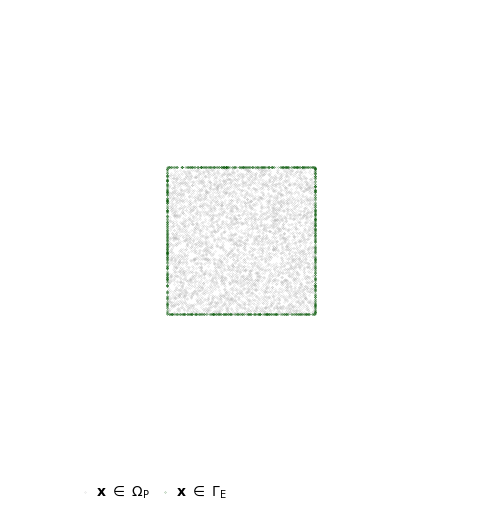

In [34]:
# Parameters
n_Omega_P = 5_000        # Number of points inside the annular region
n_Gamma_I = 100          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 300          # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4          # Inner radius
l_e = 1.              # Length of the semi-edge of the square
k = 1.0                  # Wave number
iter = 0                 # Iteration counter
side_length = 2 * l_e    # Side length of the square

# Generate points
x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top = generate_points(n_Omega_P, side_length, r_i, n_Gamma_I, n_Gamma_E)
plot_points(x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top)

In [35]:
import time
# Default to CUDA if available, otherwise CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model
model = MLP(input_size=2, output_size=2, hidden_layers=3, hidden_units=50, activation_function=nn.Tanh()).to(device)
model.apply(init_weights)

# Training with Adam optimizer
start_time_adam = time.time()
train_adam(model, x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k, num_iter=5_000)
end_time_adam = time.time()
adam_training_time = end_time_adam - start_time_adam
print(f"Adam training time: {adam_training_time:.6e} seconds")

# Training with L-BFGS optimizer
start_time_lbfgs = time.time()
train_lbfgs(model, x_f, y_f, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k, num_iter=15_000)
end_time_lbfgs = time.time()
lbfgs_training_time = end_time_lbfgs - start_time_lbfgs
print(f"LBFGS training time: {lbfgs_training_time:.6e} seconds")

# Total training time
total_training_time = adam_training_time + lbfgs_training_time
print(f"Total training time: {total_training_time:.6e} seconds")

# Save the model
torch.save(model.state_dict(), f'Scattering.pt')

Adam - Iter: 1000 - Loss: 0.015566033311188221
Adam - Iter: 2000 - Loss: 0.011906895786523819
Adam - Iter: 3000 - Loss: 0.004094562493264675
Adam - Iter: 4000 - Loss: 0.0003302712575532496
Adam - Iter: 5000 - Loss: 0.00011655340495053679
Adam training time: 1.035088e+02 seconds
Iteration 6000, Loss: 3.041973059225711e-06
Iteration 7000, Loss: 1.2895275176560972e-06
LBFGS training time: 9.365343e+01 seconds
Total training time: 1.971622e+02 seconds


In [36]:
# Save training summary to a text file
with open('datos/scattering_problem_training_times.txt', 'w') as file:
    file.write(f"Adam training time: {adam_training_time:.6e} seconds\n")
    file.write(f"LBFGS training time: {lbfgs_training_time:.6e} seconds\n")
    file.write(f"Total training time: {total_training_time:.6e} seconds\n")
    file.write(f"Total iterations: {iter}\n")

In [37]:
model=initialize_and_load_model('Scattering.pt')

In [38]:
u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns = predict_displacement_pinns(model, l_e, r_i, k, dom_samples=500)

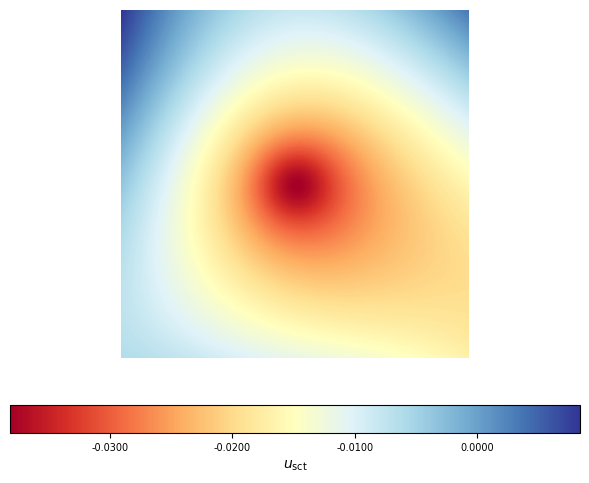

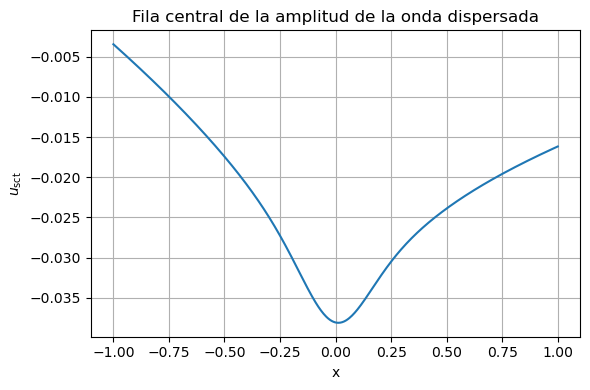

In [42]:
# Ejemplo de datos (asegúrate de reemplazar esto con tus datos reales)
X, Y = np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 500))

# Crear figura para la amplitud de la onda dispersada
fig, ax = plt.subplots(figsize=(6, 5))  # Ajustar el tamaño de la figura

# Amplitud de la onda dispersada
c = ax.pcolormesh(X, Y, u_sc_phase_pinns, cmap="RdYlBu", rasterized=True)
cb = fig.colorbar(c, ax=ax, orientation="horizontal", pad=0.1, format='%.4f')
cb.set_label(r"$u_{\rm{sct}}$")
cb.ax.tick_params(labelsize=7)  # Ajustar el tamaño de las etiquetas de los ticks

# Configurar el eje
ax.axis("off")
ax.set_aspect("equal")

# Mostrar la figura
plt.tight_layout()
plt.show()

# Graficar una fila específica de la amplitud de la onda dispersada
fila_central = u_sc_phase_pinns[u_sc_phase_pinns.shape[0] // 2, :]  # Seleccionar la fila central
plt.figure(figsize=(6, 4))
plt.plot(X[0, :], fila_central, label="Fila central (amplitud)")
plt.title("Fila central de la amplitud de la onda dispersada")
plt.xlabel("x")
plt.ylabel(r"$u_{\rm{sct}}$")
plt.grid(True)
#plt.legend()
plt.tight_layout()
plt.show()